In [1]:
import pandas as pd
import numpy as np

print("Pandas:", pd.__version__)

Pandas: 2.3.3


In [10]:
df = pd.read_excel("../data/Online Retail.xlsx")
df.shape


(541909, 8)

In [11]:
# 1. Drop rows without CustomerID
df = df.dropna(subset=["CustomerID"]).copy()

# 2. Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 3. Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# 4. Remove invalid quantity and price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# 5. Create TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.shape


(397884, 9)

In [12]:
df.describe()[["Quantity", "UnitPrice", "TotalPrice"]]


,Quantity,UnitPrice,TotalPrice
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,22.397000
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000
std,179.331775,22.097877,309.071041


In [13]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("CustomerID")
      .agg(
          Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
          Frequency=("InvoiceNo", "nunique"),
          Monetary=("TotalPrice", "sum")
      )
      .reset_index()
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [14]:
df.shape

(397884, 9)

In [15]:
# RFM scoring
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]
).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [16]:
def assign_segment(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4:
        return "Champions"
    elif row["F_Score"] >= 4:
        return "Loyal Customers"
    elif row["R_Score"] <= 2 and row["F_Score"] <= 2:
        return "At Risk"
    elif row["R_Score"] >= 4:
        return "New Customers"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(assign_segment, axis=1)

rfm["Segment"].value_counts()


Segment
Champions          1139
At Risk            1065
Others              905
New Customers       633
Loyal Customers     596
Name: count, dtype: int64

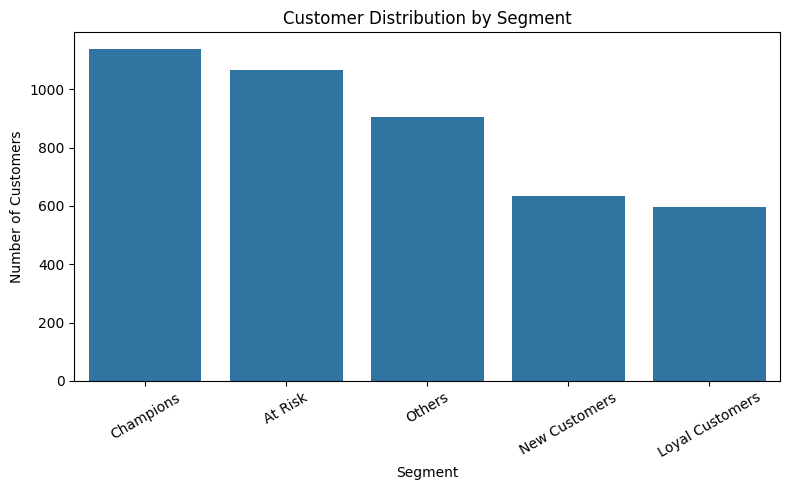

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(
    data=rfm,
    x="Segment",
    order=rfm["Segment"].value_counts().index
)
plt.title("Customer Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


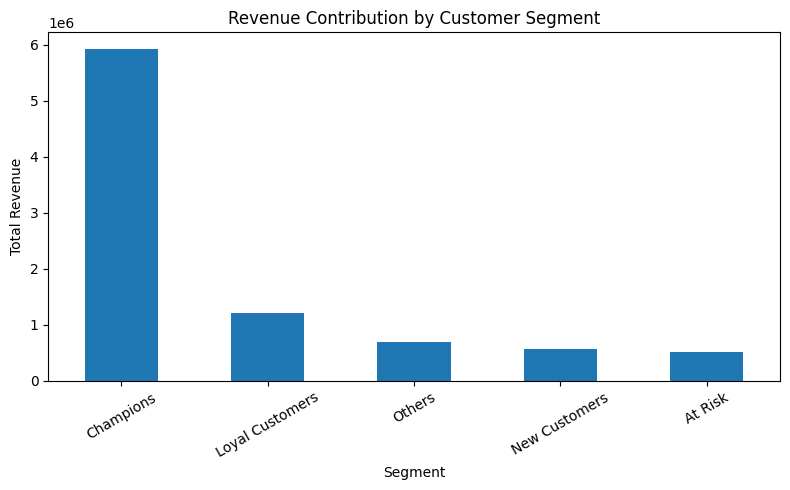

In [30]:
segment_revenue = (
    rfm.groupby("Segment")["Monetary"]
       .sum()
       .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
segment_revenue.plot(kind="bar")
plt.title("Revenue Contribution by Customer Segment")
plt.ylabel("Total Revenue")
plt.xlabel("Segment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("../images/revenue_by_segment.png", dpi=200, bbox_inches="tight")
plt.show()


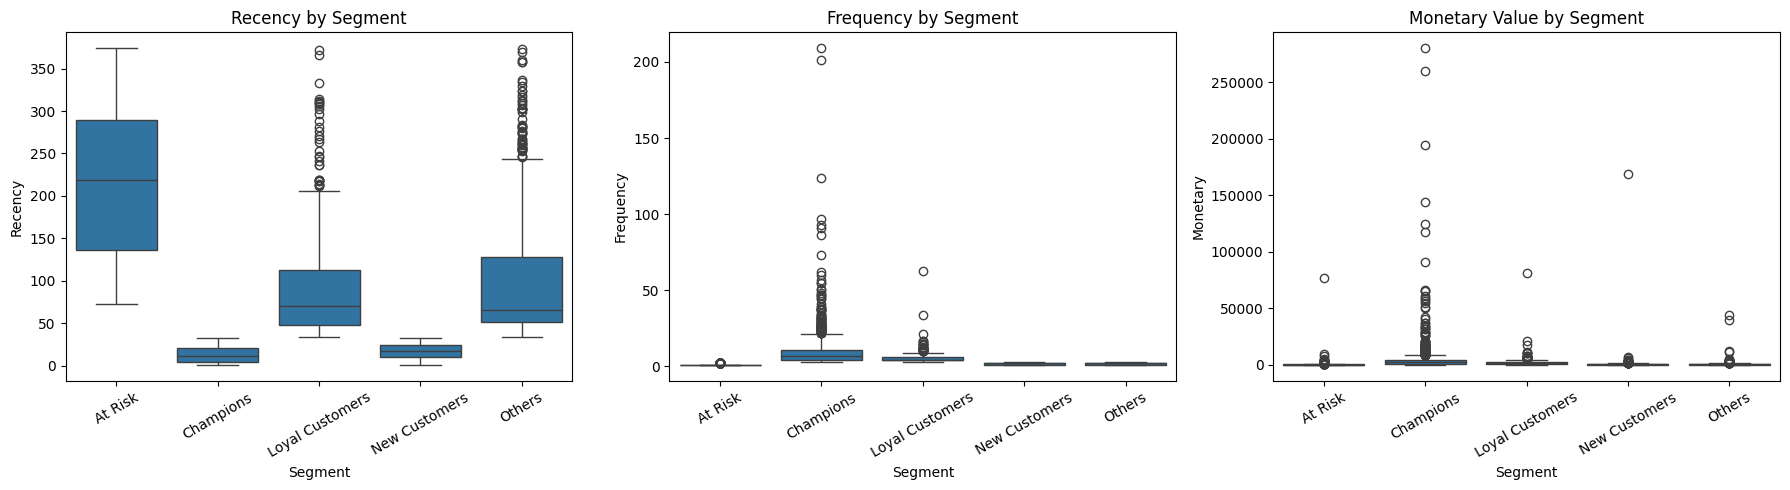

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(data=rfm, x="Segment", y="Recency", ax=axes[0])
axes[0].set_title("Recency by Segment")
axes[0].tick_params(axis='x', rotation=30)

sns.boxplot(data=rfm, x="Segment", y="Frequency", ax=axes[1])
axes[1].set_title("Frequency by Segment")
axes[1].tick_params(axis='x', rotation=30)

sns.boxplot(data=rfm, x="Segment", y="Monetary", ax=axes[2])
axes[2].set_title("Monetary Value by Segment")
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig("../images/rfm_boxplots.png", dpi=200, bbox_inches="tight")
plt.show()


In [20]:
# Create invoice month
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

# Create cohort month (first purchase month per customer)
df["CohortMonth"] = (
    df.groupby("CustomerID")["InvoiceDate"]
      .transform("min")
      .dt.to_period("M")
)

# Calculate cohort index (months since first purchase)
df["CohortIndex"] = (
    df["InvoiceMonth"] - df["CohortMonth"]
).apply(lambda x: x.n) + 1

df[["CustomerID", "InvoiceMonth", "CohortMonth", "CohortIndex"]].head()


,CustomerID,InvoiceMonth,CohortMonth,CohortIndex
0,17850.0,2010-12,2010-12,1
1,17850.0,2010-12,2010-12,1
2,17850.0,2010-12,2010-12,1
3,17850.0,2010-12,2010-12,1
4,17850.0,2010-12,2010-12,1


In [21]:
cohort_data = (
    df.groupby(["CohortMonth", "CohortIndex"])["CustomerID"]
      .nunique()
      .reset_index()
)

cohort_pivot = cohort_data.pivot(
    index="CohortMonth",
    columns="CohortIndex",
    values="CustomerID"
)

cohort_pivot.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN


In [22]:
retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)
retention.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN


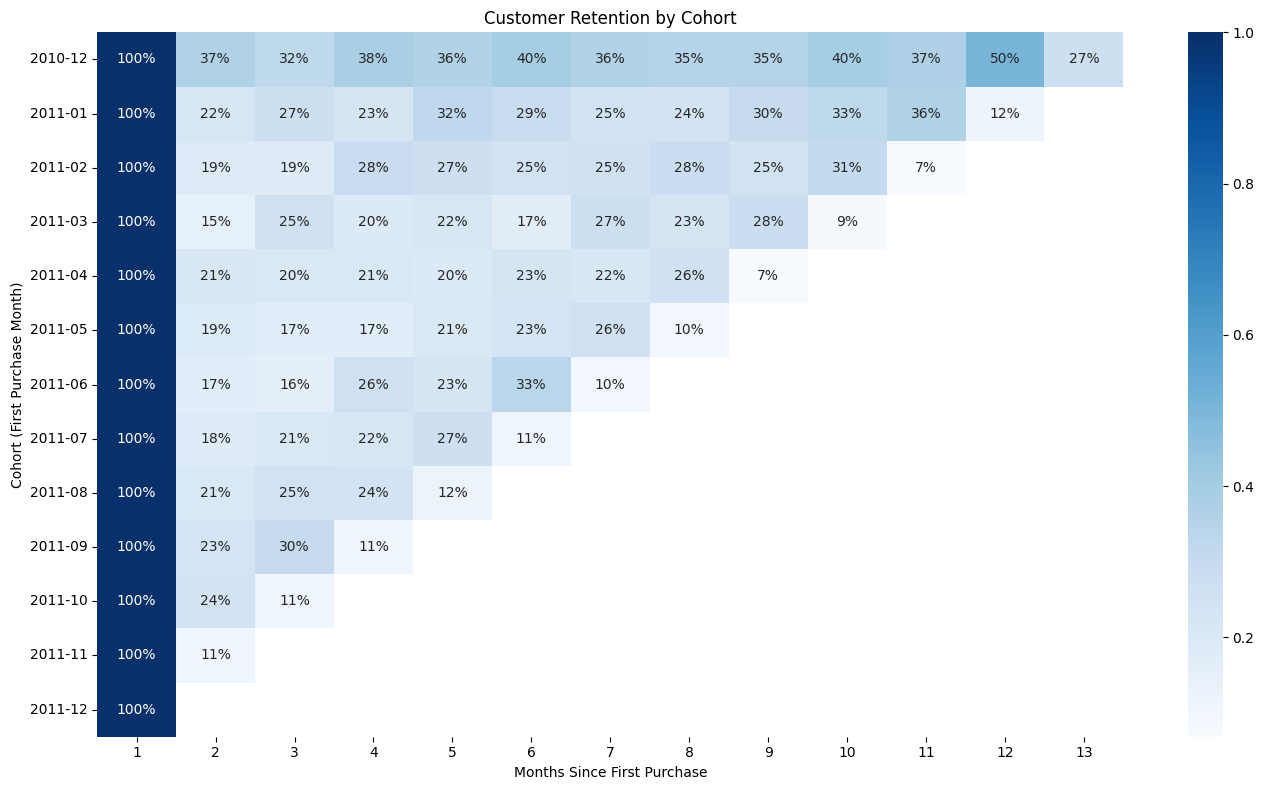

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(
    retention,
    annot=True,
    fmt=".0%",
    cmap="Blues"
)
plt.title("Customer Retention by Cohort")
plt.ylabel("Cohort (First Purchase Month)")
plt.xlabel("Months Since First Purchase")
plt.tight_layout()
plt.savefig("../images/retention_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()


In [24]:
from sklearn.preprocessing import StandardScaler

# Select features
X = rfm[["Recency", "Frequency", "Monetary"]]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


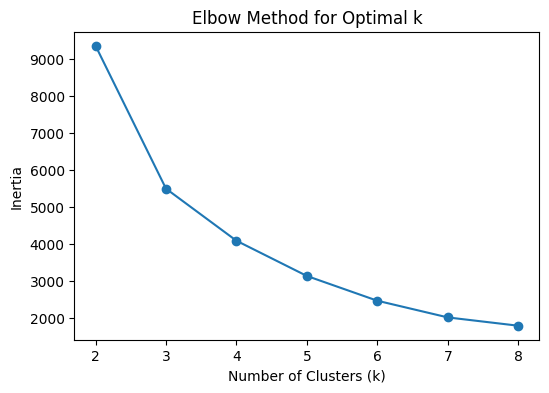

In [34]:
from sklearn.cluster import KMeans

inertia = []
K = range(2, 9)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.savefig("../images/elbow_method.png", dpi=200, bbox_inches="tight")
plt.show()


In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

rfm["KMeans_Cluster"].value_counts()


KMeans_Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64

In [27]:
cluster_summary = (
    rfm.groupby("KMeans_Cluster")
       .agg(
           Recency_mean=("Recency", "mean"),
           Frequency_mean=("Frequency", "mean"),
           Monetary_mean=("Monetary", "mean"),
           Customer_Count=("CustomerID", "count")
       )
       .round(1)
)

cluster_summary


,Recency_mean,Frequency_mean,Monetary_mean,Customer_Count
KMeans_Cluster,,,,
0,43.7,3.7,1359.0,3054
1,248.1,1.6,480.6,1067
2,7.4,82.5,127338.3,13
3,15.5,22.3,12709.1,204


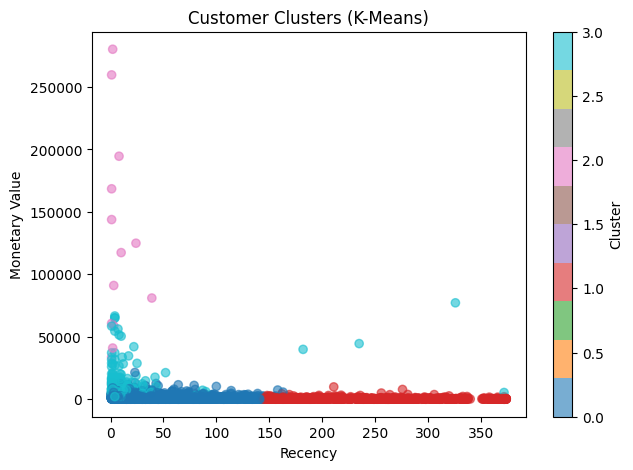

In [35]:
plt.figure(figsize=(7,5))
plt.scatter(
    rfm["Recency"],
    rfm["Monetary"],
    c=rfm["KMeans_Cluster"],
    cmap="tab10",
    alpha=0.6
)
plt.xlabel("Recency")
plt.ylabel("Monetary Value")
plt.title("Customer Clusters (K-Means)")
plt.colorbar(label="Cluster")
plt.savefig("../images/kmeans_clusters.png", dpi=200, bbox_inches="tight")
plt.show()
